# Zero-Shot PCB Defect Detection

This notebook demonstrates how to use Vision-Language Models (VLMs) for zero-shot detection of defects in PCB images.

## Overview

- **Zero-Shot Learning**: No labeled training data required
- **Prompt-Based Classification**: Uses natural language prompts to identify defect types
- **Semiconductor-Specific**: Tailored for PCB and semiconductor manufacturing defects
- **Hugging Face Integration**: Leverages pre-trained Vision Transformer (ViT) models

## Google Colab Setup

This section handles setup for running in Google Colab. It will clone the repository if needed and set up the necessary paths.

In [1]:
# Check if running in Colab
IN_COLAB = 'google.colab' in str(get_ipython())
print(f"Running in Google Colab: {IN_COLAB}")

if IN_COLAB:
    # Clone the repository if it doesn't exist
    !git clone https://github.com/your-username/pcb-defect-detection.git 2>/dev/null || echo "Repository already exists"

    # Change to the repository directory
    %cd pcb-defect-detection

    # Install required packages
    !pip install -q torch torchvision transformers pillow matplotlib numpy scikit-learn tqdm

    # Add the repository to Python path
    import sys
    if not "/content/pcb-defect-detection" in sys.path:
        sys.path.append("/content/pcb-defect-detection")
else:
    # For local execution, add the parent directory to the path if needed
    import sys
    import os
    if not os.path.abspath('..') in sys.path:
        sys.path.append(os.path.abspath('..'))

Running in Google Colab: True
Repository already exists
[Errno 2] No such file or directory: 'pcb-defect-detection'
/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.2 MB/s eta 0:00:00


In [21]:
!pip install opencv-python

## Setup and Imports

In [14]:
import os
import sys
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
from typing import List, Dict, Any, Union, Optional, Tuple

# Import Google Colab specific modules when in Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import files

# Enable showing images in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)  # Set default figure size

## Define Model and Zero-Shot Detection Classes

First, let's implement the core functionality:

In [3]:
class PCBDefectVLM:
    """PCB defect detection using Vision-Language Models."""

    def __init__(self, model_name: str = "openai/clip-vit-base-patch32"):
        """
        Initialize the Vision Language Model for PCB defect detection.

        Args:
            model_name: Hugging Face model identifier for the VLM
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        print(f"Loading model: {model_name}...")
        self.model = CLIPModel.from_pretrained(model_name).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        print("Model loaded successfully!")

    def load_image(self, image_path: str) -> Image.Image:
        """
        Load and prepare an image for inference.

        Args:
            image_path: Path to the image file

        Returns:
            PIL Image object
        """
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at {image_path}")

        return Image.open(image_path).convert("RGB")

    def classify(self, image: Union[str, Image.Image], categories: List[str]) -> Dict[str, float]:
        """
        Perform zero-shot classification on PCB image.

        Args:
            image: Path to image or PIL Image object
            categories: List of defect categories as text prompts

        Returns:
            Dictionary of category -> probability mappings
        """
        try:
            if isinstance(image, str):
                try:
                    image = self.load_image(image)
                except Exception as e:
                    print(f"Error loading image: {e}")
                    return {"error": "Failed to load image"}

            # Prepare text prompts for the model
            text_inputs = self.processor(
                text=categories,
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(self.device)

            # Prepare image for the model
            image_inputs = self.processor(
                images=image,
                return_tensors="pt"
            ).to(self.device)

            # Get embeddings
            with torch.no_grad():
                image_features = self.model.get_image_features(**image_inputs)
                text_features = self.model.get_text_features(**text_inputs)

                # Normalize features
                image_features = image_features / image_features.norm(dim=1, keepdim=True)
                text_features = text_features / text_features.norm(dim=1, keepdim=True)

                # Calculate similarity scores
                logits_per_image = (100.0 * image_features @ text_features.T).squeeze(0)
                probs = logits_per_image.softmax(dim=0)

            # Create and return results dictionary
            results = {}
            for category, prob in zip(categories, probs.cpu().numpy()):
                results[category] = float(prob)

            return results

        except torch.cuda.CudaError as e:
            print(f"CUDA error: {e}")
            # Clear CUDA cache and retry once
            torch.cuda.empty_cache()
            return {"error": str(e)}

        except Exception as e:
            print(f"Unexpected error: {e}")
            return {"error": str(e)}

    def classify_batch_optimized(self, images: List[Union[str, Image.Image]],
                              categories: List[str],
                              batch_size: int = 16) -> List[Dict[str, float]]:
        """
        Optimized batch classification with memory management.

        Args:
            images: List of image paths or PIL Image objects
            categories: List of defect categories as text prompts
            batch_size: Maximum batch size to process at once

        Returns:
            List of dictionaries mapping categories to probabilities
        """
        results = []

        # Process images in smaller batches to avoid OOM errors
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i+batch_size]

            # Load images if paths are provided
            loaded_images = []
            valid_indices = []

            for idx, img in enumerate(batch_images):
                try:
                    if isinstance(img, str):
                        loaded_images.append(self.load_image(img))
                    else:
                        loaded_images.append(img)
                    valid_indices.append(idx + i)
                except Exception as e:
                    print(f"Error loading image {img}: {e}")
                    results.append({"error": str(e)})

            if not loaded_images:
                continue

            try:
                # Prepare text prompts for the model
                text_inputs = self.processor(
                    text=categories,
                    return_tensors="pt",
                    padding=True,
                    truncation=True
                ).to(self.device)

                # Prepare images for the model
                image_inputs = self.processor(
                    images=loaded_images,
                    return_tensors="pt",
                    padding=True
                ).to(self.device)

                # Get embeddings with memory management
                with torch.no_grad():
                    image_features = self.model.get_image_features(**image_inputs)
                    text_features = self.model.get_text_features(**text_inputs)

                    # Normalize features
                    image_features = image_features / image_features.norm(dim=1, keepdim=True)
                    text_features = text_features / text_features.norm(dim=1, keepdim=True)

                    # Calculate similarity scores
                    logits_per_image = (100.0 * image_features @ text_features.T)
                    probs = logits_per_image.softmax(dim=-1)

                    # Move to CPU to free GPU memory
                    probs_cpu = probs.cpu().numpy()

                # Clear GPU memory
                torch.cuda.empty_cache()

                # Create and return results
                batch_results = []
                for prob_set in probs_cpu:
                    result = {}
                    for category, prob in zip(categories, prob_set):
                        result[category] = float(prob)
                    batch_results.append(result)

                # Insert batch results at the correct positions
                for idx, result in zip(valid_indices, batch_results):
                    if idx >= len(results):
                        # Extend the results list if needed
                        results.extend([None] * (idx - len(results) + 1))
                    results[idx] = result

            except Exception as e:
                print(f"Error processing batch: {e}")
                # Fill results with error for this batch
                for _ in range(len(batch_images)):
                    results.append({"error": str(e)})

        # Fill any None values with error messages
        results = [r if r is not None else {"error": "Processing failed"} for r in results]

        return results

In [31]:
class PCBDefectDetector:
    """Zero-shot PCB defect detection with prompt-based categorization."""

    def __init__(self, model_name: str = "openai/clip-vit-base-patch32"):
        """
        Initialize the PCB defect detector.

        Args:
            model_name: Hugging Face model identifier for the VLM
        """
        self.vlm = PCBDefectVLM(model_name=model_name)
        self.defect_categories = []
        self.defect_prompts = {}
        self._cached_prompts = None
        self._cached_prompts_params = None

    def load_defect_categories(self, json_path: str = None) -> None:
        """
        Load defect categories and prompts from a JSON file or use defaults.

        Args:
            json_path: Path to the JSON file containing defect categories
        """
        if json_path and os.path.exists(json_path):
            with open(json_path, 'r') as f:
                data = json.load(f)

            self.defect_categories = [item['category'] for item in data['defects']]

            # Store the detailed prompts for each category
            self.defect_prompts = {}
            for item in data['defects']:
                self.defect_prompts[item['category']] = item['prompts']
        else:
            print("Using default defect categories...")
            # Default defect categories for PCBs
            self.defect_categories = [
                "Solder Bridge",
                "Missing Component",
                "Component Misalignment",
                "Cold Solder Joint",
                "Lifted Pad",
                "Excess Solder",
                "Insufficient Solder",
                "Cracked Solder Joint",
                "PCB Scratch",
                "Burnt Component",
                "Reversed Component",
                "Foreign Material"
            ]

            # Default prompts for each category
            self.defect_prompts = {
                "Solder Bridge": [
                    "solder bridging between adjacent pins",
                    "short circuit between traces or pads"
                ],
                "Missing Component": [
                    "missing electronic component",
                    "component placement area with no part installed"
                ],
                "Component Misalignment": [
                    "misaligned component on the PCB",
                    "component shifted from its correct position"
                ],
                "Cold Solder Joint": [
                    "cold solder joint",
                    "dull, grainy solder connection"
                ],
                "Lifted Pad": [
                    "pad lifted from PCB substrate",
                    "copper pad delamination"
                ],
                "Excess Solder": [
                    "too much solder on joint",
                    "solder ball or blob"
                ],
                "Insufficient Solder": [
                    "not enough solder on joint",
                    "incomplete solder coverage"
                ],
                "Cracked Solder Joint": [
                    "cracked solder connection",
                    "fracture in solder joint"
                ],
                "PCB Scratch": [
                    "scratch on PCB surface",
                    "damaged trace on board"
                ],
                "Burnt Component": [
                    "burnt or charred component",
                    "blackened electronic part"
                ],
                "Reversed Component": [
                    "component installed backwards",
                    "reversed polarity component"
                ],
                "Foreign Material": [
                    "debris on PCB surface",
                    "contaminant on circuit board"
                ]
            }

    def get_prompts_for_detection(self, enhance_with_domain: bool = True) -> List[str]:
        """
        Generate prompts for zero-shot detection.

        Args:
            enhance_with_domain: Whether to enhance prompts with domain-specific language

        Returns:
            List of formatted prompts for the model
        """
        if not self.defect_categories:
            self.load_defect_categories()

        detection_prompts = []

        for category in self.defect_categories:
            # Get the most generic prompt for this category
            base_prompt = self.defect_prompts[category][0]

            if enhance_with_domain:
                # Format with PCB/semiconductor domain knowledge
                prompt = f"A PCB with {base_prompt}"
                prompt_alt = f"A printed circuit board showing {base_prompt}"
                detection_prompts.extend([prompt, prompt_alt])
            else:
                detection_prompts.append(base_prompt)

        # Always add a "normal" category
        detection_prompts.append("A normal PCB with no defects")
        detection_prompts.append("A perfectly manufactured printed circuit board")

        return detection_prompts

    def detect(self, image_path: str, threshold: float = 0.2,
               top_k: int = 3, enhance_prompts: bool = True) -> Dict[str, Any]:
        """
        Detect PCB defects in an image using zero-shot classification.

        Args:
            image_path: Path to the PCB image
            threshold: Confidence threshold for detection (0-1)
            top_k: Number of top categories to return
            enhance_prompts: Whether to enhance prompts with domain-specific language

        Returns:
            Detection results with categories and confidence scores
        """
        # Validate input parameters
        if not 0 <= threshold <= 1:
            raise ValueError("Threshold must be between 0 and 1")

        if top_k < 1:
            raise ValueError("top_k must be at least 1")

        # Check if image exists
        if not os.path.exists(image_path):
            return {
                "is_defective": False,
                "defects": {},
                "all_scores": {},
                "error": f"Image not found at {image_path}"
            }

        # Get formatted prompts (with caching)
        if not self._cached_prompts or self._cached_prompts_params != enhance_prompts:
            self._cached_prompts = self.get_prompts_for_detection(enhance_with_domain=enhance_prompts)
            self._cached_prompts_params = enhance_prompts

        prompts = self._cached_prompts

        try:
            # Perform zero-shot classification
            raw_results = self.vlm.classify(image_path, prompts)

            # Check if we got an error from the model
            if "error" in raw_results:
                return {
                    "is_defective": False,
                    "defects": {},
                    "all_scores": {},
                    "error": raw_results["error"]
                }

            # Post-process results to combine similar categories
            processed_results = self._process_results(raw_results)
            normal_score = processed_results.get("Normal", 0.0)

            # Get top defect score
            defect_scores = {k: v for k, v in processed_results.items() if k != "Normal"}
            top_defect_score = max(defect_scores.values()) if defect_scores else 0.0

            is_defective = top_defect_score > (normal_score * 1.2)  # 20% buffer for normal


            return {
                "is_defective": is_defective,
                "defects": top_k_results,
                "all_scores": processed_results
            }

        except Exception as e:
            print(f"Error in defect detection: {e}")
            return {
                "is_defective": False,
                "defects": {},
                "all_scores": {},
                "error": str(e)
            }

    def _process_results(self, raw_results: Dict[str, float]) -> Dict[str, float]:
        """
        Process raw classification results to combine similar categories.

        Args:
            raw_results: Raw classification results

        Returns:
            Processed results with combined categories
        """
        processed = {}

        # Group by category and take maximum score
        for prompt, score in raw_results.items():
            # Skip error messages
            if prompt == "error":
                continue

            # Extract the category from the prompt using more robust matching
            category = None
            for cat in self.defect_categories:
                # Use word-level matching for better accuracy
                if any(word.lower() in prompt.lower().split() for word in cat.lower().split()):
                    category = cat
                    break

            # Handle "normal" prompts with improved logic
            if "normal" in prompt.lower() or "no defects" in prompt.lower():
                category = "Normal"

            if category:
                if category in processed:
                    processed[category] = max(processed[category], score)
                else:
                    processed[category] = score

        # Add normalization to make scores more comparable
        if processed:
            total = sum(processed.values())
            if total > 0:  # Avoid division by zero
                processed = {k: v/total for k, v in processed.items()}

        return processed

    def batch_detect(self, image_paths: List[str], threshold: float = 0.2,
                    top_k: int = 3, enhance_prompts: bool = True, batch_size: int = 16) -> List[Dict[str, Any]]:
        """
        Detect PCB defects in multiple images using optimized batch processing.

        Args:
            image_paths: List of paths to PCB images
            threshold: Confidence threshold for detection
            top_k: Number of top categories to return
            enhance_prompts: Whether to enhance prompts with domain-specific language
            batch_size: Size of batches to process at once

        Returns:
            List of detection results for each image
        """
        # Validate input parameters
        if not 0 <= threshold <= 1:
            raise ValueError("Threshold must be between 0 and 1")

        if top_k < 1:
            raise ValueError("top_k must be at least 1")

        # Get formatted prompts (with caching)
        if not self._cached_prompts or self._cached_prompts_params != enhance_prompts:
            self._cached_prompts = self.get_prompts_for_detection(enhance_with_domain=enhance_prompts)
            self._cached_prompts_params = enhance_prompts

        prompts = self._cached_prompts

        # Perform batch classification with optimized function
        raw_batch_results = self.vlm.classify_batch_optimized(
            images=image_paths,
            categories=prompts,
            batch_size=batch_size
        )

        # Process each result
        results = []
        for i, raw_result in enumerate(raw_batch_results):
            try:
                # Check if we got an error
                if "error" in raw_result:
                    results.append({
                        "is_defective": False,
                        "defects": {},
                        "all_scores": {},
                        "error": raw_result["error"],
                        "image_path": image_paths[i] if i < len(image_paths) else "unknown"
                    })
                    continue

                # Post-process results to combine similar categories
                processed_result = self._process_results(raw_result)

                # Get top k results above threshold
                top_results = {k: v for k, v in sorted(
                    processed_result.items(),
                    key=lambda item: item[1],
                    reverse=True
                ) if v >= threshold}

                # Handle case where no categories meet threshold
                if not top_results:
                    # Return the highest scoring category regardless of threshold
                    if processed_result:
                        top_item = max(processed_result.items(), key=lambda x: x[1])
                        top_results = {top_item[0]: top_item[1]}
                    else:
                        top_results = {"Unknown": 0.0}

                # Limit to top k
                top_k_results = dict(list(top_results.items())[:top_k])

                # Improved defect detection logic
                normal_score = 0
                defect_score = 0

                for cat, score in top_k_results.items():
                    if cat.lower() == "normal":
                        normal_score += score
                    else:
                        defect_score += score

                # More nuanced decision
                is_defective = defect_score > normal_score

                # Add the result
                results.append({
                    "is_defective": is_defective,
                    "defects": top_k_results,
                    "all_scores": processed_result,
                    "image_path": image_paths[i] if i < len(image_paths) else "unknown"
                })

            except Exception as e:
                print(f"Error processing result {i}: {e}")
                results.append({
                    "is_defective": False,
                    "defects": {},
                    "all_scores": {},
                    "error": str(e),
                    "image_path": image_paths[i] if i < len(image_paths) else "unknown"
                })

        return results

## Visualization Functions

Let's define some helper functions to visualize our results:

In [32]:
def visualize_detection(image_path: str, results: Dict[str, Any],
                        output_path: Optional[str] = None,
                        show: bool = True) -> None:
    """
    Visualize defect detection results with confidence scores.

    Args:
        image_path: Path to the PCB image
        results: Detection results from PCBDefectDetector
        output_path: Optional path to save the visualization
        show: Whether to display the plot
    """
    # Load image
    img = Image.open(image_path)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Plot image
    ax1.imshow(np.array(img))
    ax1.set_title("PCB Image")
    ax1.axis('off')

    # Plot defect scores
    defects = results['defects']
    categories = list(defects.keys())
    scores = list(defects.values())

    if not categories:
        ax2.text(0.5, 0.5, "No defects detected",
                ha='center', va='center', fontsize=12)
        ax2.axis('off')
    else:
        # Sort by score in descending order
        sorted_indices = np.argsort(scores)[::-1]
        categories = [categories[i] for i in sorted_indices]
        scores = [scores[i] for i in sorted_indices]

        # Set colors based on defect status
        colors = ['red' if category.lower() != "normal" else 'green' for category in categories]

        # Plot horizontal bar chart
        y_pos = np.arange(len(categories))
        bars = ax2.barh(y_pos, scores, color=colors, alpha=0.7)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(categories)
        ax2.set_xlim(0, 1.0)
        ax2.set_xlabel('Confidence Score')

        # Add score values
        for bar, score in zip(bars, scores):
            ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{score:.2f}', va='center')

    # Determine overall status
    if results['is_defective']:
        status_text = "DEFECTIVE"
        status_color = "red"
    else:
        status_text = "NORMAL"
        status_color = "green"

    ax2.set_title(f"Detection Results: {status_text}", color=status_color, fontweight='bold')

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {output_path}")

    if show:
        plt.show()
    else:
        plt.close()

def create_comparison_grid(image_paths: List[str], results: List[Dict[str, Any]],
                           output_path: Optional[str] = None,
                           grid_size: Optional[Tuple[int, int]] = None,
                           show: bool = True) -> None:
    """
    Create a grid of PCB images with their detection results.

    Args:
        image_paths: List of paths to PCB images
        results: List of detection results
        output_path: Optional path to save the visualization
        grid_size: Optional tuple of (rows, cols) for the grid layout
        show: Whether to display the plot
    """
    n_images = len(image_paths)

    if grid_size is None:
        # Calculate grid size based on number of images
        cols = min(4, n_images)
        rows = (n_images + cols - 1) // cols
    else:
        rows, cols = grid_size

    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    # Handle single row or column case
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    # Plot each image with its top defect
    for i, (image_path, result) in enumerate(zip(image_paths, results)):
        if i >= rows * cols:
            break

        row, col = i // cols, i % cols
        ax = axes[row, col]

        # Load and display image
        img = Image.open(image_path)
        ax.imshow(np.array(img))

        # Handle error case
        if "error" in result:
            ax.set_title(f"Error: {result['error'][:20]}...", color='orange')
            ax.axis('off')
            continue

        # Get top defect
        defects = result['defects']
        if defects:
            top_defect = list(defects.keys())[0]
            top_score = list(defects.values())[0]

            # Set color based on defect status
            color = 'red' if result['is_defective'] else 'green'

            # Set title with top defect and score
            ax.set_title(f"{top_defect}\n({top_score:.2f})", color=color)
        else:
            ax.set_title("No defects detected")

        ax.axis('off')

    # Hide unused subplots
    for i in range(n_images, rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Comparison grid saved to {output_path}")

    if show:
        plt.show()
    else:
        plt.close()

## Google Colab Image Upload

Let's implement functions for easy upload of PCB images in Colab:

In [33]:
def upload_images():
    """Upload PCB images through Google Colab interface with improved error handling"""
    if not 'google.colab' in str(get_ipython()):
        print("This function only works in Google Colab")
        return []

    print("Please upload your PCB images...")

    # Create directory structure
    upload_dir = "data/images"
    normal_dir = os.path.join(upload_dir, "normal")
    defective_dir = os.path.join(upload_dir, "defective")

    os.makedirs(normal_dir, exist_ok=True)
    os.makedirs(defective_dir, exist_ok=True)

    # Try alternative method to handle large files
    from google.colab import files

    try:
        uploaded = files.upload()

        image_paths = []
        for filename, content in uploaded.items():
            # Determine directory based on filename
            if "normal" in filename.lower():
                save_dir = normal_dir
            else:
                save_dir = defective_dir

            file_path = os.path.join(save_dir, filename)
            with open(file_path, 'wb') as f:
                f.write(content)
            print(f"Saved {filename} to {file_path}")
            image_paths.append(file_path)

        return image_paths

    except Exception as e:
        print(f"Error during upload: {e}")
        print("\nAlternative: Try using the file browser on the left sidebar:")
        print("1. Click on the folder icon in the left sidebar")
        print("2. Upload your images to the 'data/images/normal' and 'data/images/defective' folders")
        print("3. Run the cell below to use these uploaded images")
        return []

def upload_defect_json():
    """Upload custom defect categories JSON file"""
    if not 'google.colab' in str(get_ipython()):
        print("This function only works in Google Colab")
        return None

    print("Please upload your defect categories JSON file...")
    print("(Skip this if you want to use the default categories)")

    try:
        uploaded = files.upload()

        if not uploaded:
            print("No file uploaded, using default categories.")
            return None

        # Save the first uploaded file
        filename = list(uploaded.keys())[0]

        # Ensure directories exist
        os.makedirs("data/prompts", exist_ok=True)

        # Save the file
        json_path = "data/prompts/defect_categories.json"
        with open(json_path, 'wb') as f:
            f.write(uploaded[filename])

        print(f"Saved {filename} to {json_path}")
        return json_path
    except Exception as e:
        print(f"Error uploading JSON: {e}")
        return None

In [30]:
def find_uploaded_images():
    """Find images in various possible directory structures without duplicates"""
    # Check common directory variations
    possible_dirs = [
        ("data/images/normal", "data/images/defective"),
        ("data/images/normal", "data/images/defect"),  # Note "defect" instead of "defective"
        ("data/normal", "data/defective"),
        ("data/normal", "data/defect"),
        ("normal", "defective"),
        ("normal", "defect"),
        ("./data/images/normal", "./data/images/defective"),
        ("./data/images/normal", "./data/images/defect")
    ]

    # Use a set to store unique image paths
    found_images = set()

    for normal_dir, defective_dir in possible_dirs:
        if os.path.exists(normal_dir):
            print(f"Checking directory: {normal_dir}")
            for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                for img_path in glob.glob(os.path.join(normal_dir, f"*{ext}")) + glob.glob(os.path.join(normal_dir, f"*{ext.upper()}")):
                    # Convert to absolute path to avoid duplicates
                    abs_path = os.path.abspath(img_path)
                    if abs_path not in found_images:
                        found_images.add(abs_path)
                        print(f" - Found normal image: {img_path}")

        if os.path.exists(defective_dir):
            print(f"Checking directory: {defective_dir}")
            for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                for img_path in glob.glob(os.path.join(defective_dir, f"*{ext}")) + glob.glob(os.path.join(defective_dir, f"*{ext.upper()}")):
                    # Convert to absolute path to avoid duplicates
                    abs_path = os.path.abspath(img_path)
                    if abs_path not in found_images:
                        found_images.add(abs_path)
                        print(f" - Found defective image: {img_path}")

    # Convert set back to list
    all_images = list(found_images)

    if all_images:
        print(f"\nFound a total of {len(all_images)} unique images")
    else:
        print("\nNo images found anywhere. Please check your file paths.")

    return all_images

### Diagnostics cell

In [44]:
# Diagnostic cell to check directory structure
print("Current working directory:", os.getcwd())
print("\nListing files in current directory:")
!rm -Rf *.png
!rm -Rf /content/data/images/normal/*.png
!rm -Rf /content/data/images/defective/*.png
!ls -la

print("\nListing files in data directory (if it exists):")
if os.path.exists("data"):
    !ls -la data
else:
    print("data directory not found")

print("\nListing files in data/images directory (if it exists):")
if os.path.exists("data/images"):
    !ls -la data/images
else:
    print("data/images directory not found")

Current working directory: /content

Listing files in current directory:
total 732
drwxr-xr-x 1 root root   4096 Apr 13 21:30 .
drwxr-xr-x 1 root root   4096 Apr 13 20:16 ..
drwxr-xr-x 4 root root   4096 Apr 10 13:37 .config
drwxr-xr-x 4 root root   4096 Apr 13 20:28 data
-rw-r--r-- 1 root root 723044 Apr 13 21:21 pcb_detection_results.zip
drwxr-xr-x 2 root root   4096 Apr 13 21:21 results
drwxr-xr-x 1 root root   4096 Apr 10 13:37 sample_data

Listing files in data directory (if it exists):
total 16
drwxr-xr-x 4 root root 4096 Apr 13 20:28 .
drwxr-xr-x 1 root root 4096 Apr 13 21:30 ..
drwxr-xr-x 4 root root 4096 Apr 13 20:28 images
drwxr-xr-x 2 root root 4096 Apr 13 20:22 prompts

Listing files in data/images directory (if it exists):
total 16
drwxr-xr-x 4 root root 4096 Apr 13 20:28 .
drwxr-xr-x 4 root root 4096 Apr 13 20:28 ..
drwxr-xr-x 2 root root 4096 Apr 13 21:30 defective
drwxr-xr-x 2 root root 4096 Apr 13 21:30 normal


## PCB Defect Categories

Let's define the defect categories in a JSON format:

In [7]:
def create_default_defect_categories():
    """Create and save default defect categories"""
    # Define defect categories
    defect_categories = {
        "defects": [
            {
                "category": "Solder Bridge",
                "prompts": [
                    "solder bridging between adjacent pins",
                    "short circuit between traces or pads",
                    "excess solder creating unwanted connections"
                ],
                "severity": "high"
            },
            {
                "category": "Missing Component",
                "prompts": [
                    "missing electronic component",
                    "component placement area with no part installed",
                    "empty pad where a component should be"
                ],
                "severity": "high"
            },
            {
                "category": "Component Misalignment",
                "prompts": [
                    "misaligned component on the PCB",
                    "component shifted from its correct position",
                    "rotated or tilted component"
                ],
                "severity": "medium"
            },
            {
                "category": "Cold Solder Joint",
                "prompts": [
                    "cold solder joint",
                    "dull, grainy solder connection",
                    "incomplete solder wetting"
                ],
                "severity": "high"
            },
            {
                "category": "Lifted Pad",
                "prompts": [
                    "pad lifted from PCB substrate",
                    "copper pad delamination",
                    "detached pad from board"
                ],
                "severity": "high"
            },
            {
                "category": "Excess Solder",
                "prompts": [
                    "too much solder on joint",
                    "solder ball or blob",
                    "overflowed solder joint"
                ],
                "severity": "medium"
            },
            {
                "category": "Insufficient Solder",
                "prompts": [
                    "not enough solder on joint",
                    "incomplete solder coverage",
                    "starved solder joint"
                ],
                "severity": "high"
            },
            {
                "category": "PCB Scratch",
                "prompts": [
                    "scratch on PCB surface",
                    "damaged trace on board",
                    "visible gouge in PCB"
                ],
                "severity": "medium"
            },
            {
                "category": "Burnt Component",
                "prompts": [
                    "burnt or charred component",
                    "blackened electronic part",
                    "component with burn marks"
                ],
                "severity": "high"
            },
            {
                "category": "Foreign Material",
                "prompts": [
                    "debris on PCB surface",
                    "contaminant on circuit board",
                    "flux residue on board"
                ],
                "severity": "medium"
            }
        ]
    }

    # Ensure directories exist
    os.makedirs('data/prompts', exist_ok=True)

    # Save defect categories to a JSON file
    json_path = 'data/prompts/defect_categories.json'
    with open(json_path, 'w') as f:
        json.dump(defect_categories, f, indent=4)

    print(f"Default defect categories saved to {json_path}")
    return json_path

# Create default categories if running in Colab or if requested
if 'google.colab' in str(get_ipython()) or 'create_defaults' not in locals():
    create_defaults = True

if 'create_defaults' in locals() and create_defaults:
    default_categories_path = create_default_defect_categories()

Default defect categories saved to data/prompts/defect_categories.json


## Initialize the Detector

Now let's initialize our PCB defect detector:

In [36]:
# Upload custom defect categories if desired (or use defaults)
if 'google.colab' in str(get_ipython()):
    json_path = upload_defect_json()
else:
    json_path = 'data/prompts/defect_categories.json'

# Initialize the detector with the CLIP model
detector = PCBDefectDetector(model_name="openai/clip-vit-base-patch32")

# Load defect categories
detector.load_defect_categories(json_path)

# Check the loaded categories
print("\nLoaded defect categories:")
for category in detector.defect_categories:
    print(f"- {category}")

Please upload your defect categories JSON file...
(Skip this if you want to use the default categories)


No file uploaded, using default categories.
Using device: cpu
Loading model: openai/clip-vit-base-patch32...
Model loaded successfully!
Using default defect categories...

Loaded defect categories:
- Solder Bridge
- Missing Component
- Component Misalignment
- Cold Solder Joint
- Lifted Pad
- Excess Solder
- Insufficient Solder
- Cracked Solder Joint
- PCB Scratch
- Burnt Component
- Reversed Component
- Foreign Material


### Upload images for testing

In [39]:
# Create helper function to upload images to specific directories
def upload_images_to_directory(directory):
    """Upload images directly to a specific directory"""
    from google.colab import files
    import os

    # Ensure directory exists
    os.makedirs(directory, exist_ok=True)

    print(f"Please upload images for the {os.path.basename(directory)} directory...")
    try:
        uploaded = files.upload()

        for filename, content in uploaded.items():
            file_path = os.path.join(directory, filename)
            with open(file_path, 'wb') as f:
                f.write(content)
            print(f"Saved {filename} to {file_path}")

        # Check if files were actually saved
        image_files = [f for f in os.listdir(directory)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        print(f"Total images in {directory}: {len(image_files)}")
        for img in image_files:
            print(f" - {img}")

        return [os.path.join(directory, f) for f in image_files]
    except Exception as e:
        print(f"Error during upload: {e}")
        return []

# Upload normal images
normal_images = upload_images_to_directory("/content/data/images/normal")

# Upload defective images
defective_images = upload_images_to_directory("/content/data/images/defective")

# Combine all image paths
all_images = normal_images + defective_images

print(f"\nTotal images: {len(all_images)}")
if all_images:
    print("Images are ready for analysis")
else:
    print("No images were successfully uploaded")

Please upload images for the normal directory...


Saving normal1.png to normal1.png
Saving normal2.png to normal2.png
Saved normal1.png to /content/data/images/normal/normal1.png
Saved normal2.png to /content/data/images/normal/normal2.png
Total images in /content/data/images/normal: 2
 - normal1.png
 - normal2.png
Please upload images for the defective directory...


Saving defective1.png to defective1.png
Saving defective2.png to defective2.png
Saved defective1.png to /content/data/images/defective/defective1.png
Saved defective2.png to /content/data/images/defective/defective2.png
Total images in /content/data/images/defective: 2
 - defective1.png
 - defective2.png

Total images: 4
Images are ready for analysis


## Upload and Analyze PCB Images

Now you can upload and analyze your PCB images:

Please upload your PCB images for defect detection:
Please upload your PCB images...



Looking for images in data directories...
Checking directory: data/images/normal
 - Found normal image: data/images/normal/normal1.png
 - Found normal image: data/images/normal/normal2.png
Checking directory: data/images/defective
 - Found defective image: data/images/defective/defective1.png
 - Found defective image: data/images/defective/defective2.png
Checking directory: data/images/normal
Checking directory: ./data/images/normal
Checking directory: ./data/images/defective
Checking directory: ./data/images/normal

Found a total of 4 unique images

Analyzing 4 PCB images with optimized batch processing...

Analysis complete! Visualizing results...

Processing defective1.png...
Top detected defects:
  - PCB Scratch: 0.3492
  - Missing Component: 0.2436
  - Solder Bridge: 0.1937
  - Lifted Pad: 0.1501
Overall status: DEFECTIVE
Visualization saved to results/image_1_detection.png


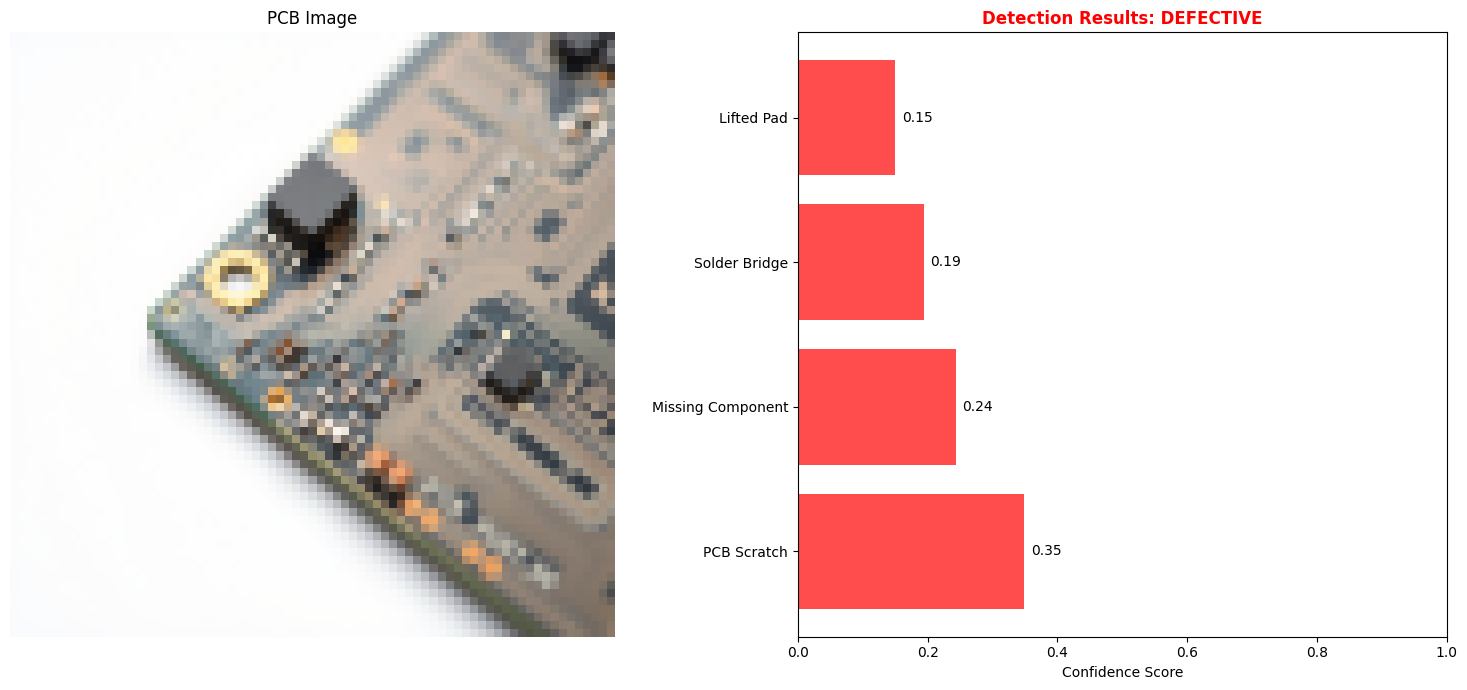


Processing defective2.png...
Top detected defects:
  - Missing Component: 0.3366
  - Solder Bridge: 0.2249
  - PCB Scratch: 0.2064
  - Lifted Pad: 0.1928
Overall status: DEFECTIVE
Visualization saved to results/image_2_detection.png


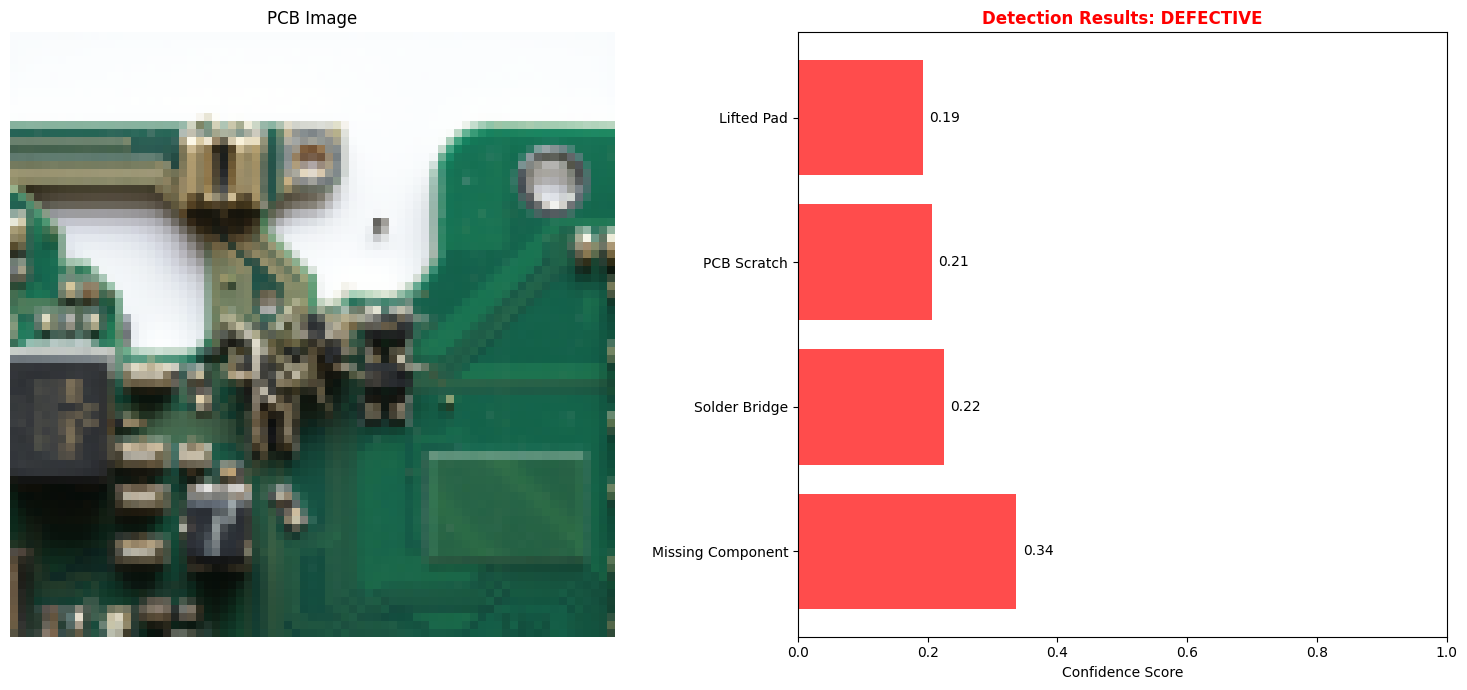


Processing normal1.png...
Top detected defects:
  - Missing Component: 0.3878
  - PCB Scratch: 0.2735
  - Normal: 0.1556
  - Lifted Pad: 0.1024
Overall status: DEFECTIVE
Visualization saved to results/image_3_detection.png


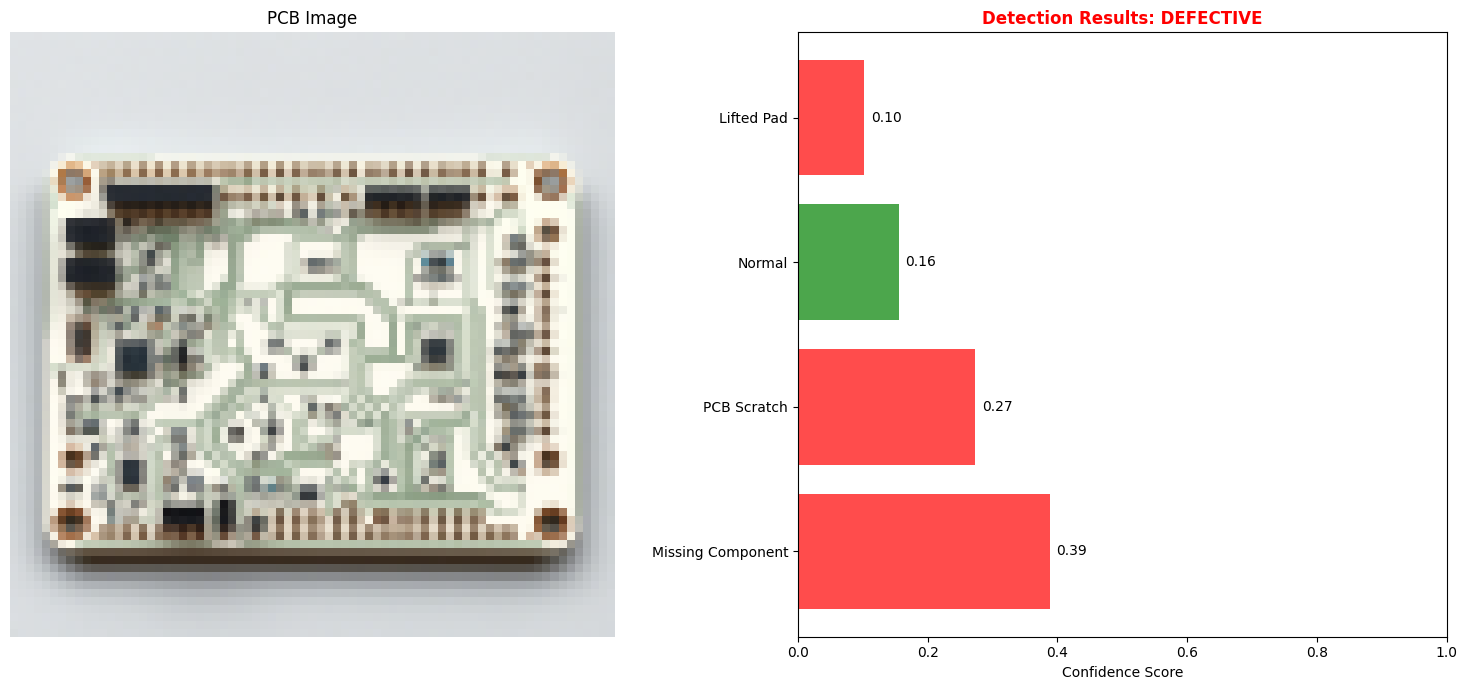


Processing normal2.png...
Top detected defects:
  - Missing Component: 0.5202
  - Normal: 0.1675
  - Solder Bridge: 0.1251
  - PCB Scratch: 0.1031
Overall status: DEFECTIVE
Visualization saved to results/image_4_detection.png


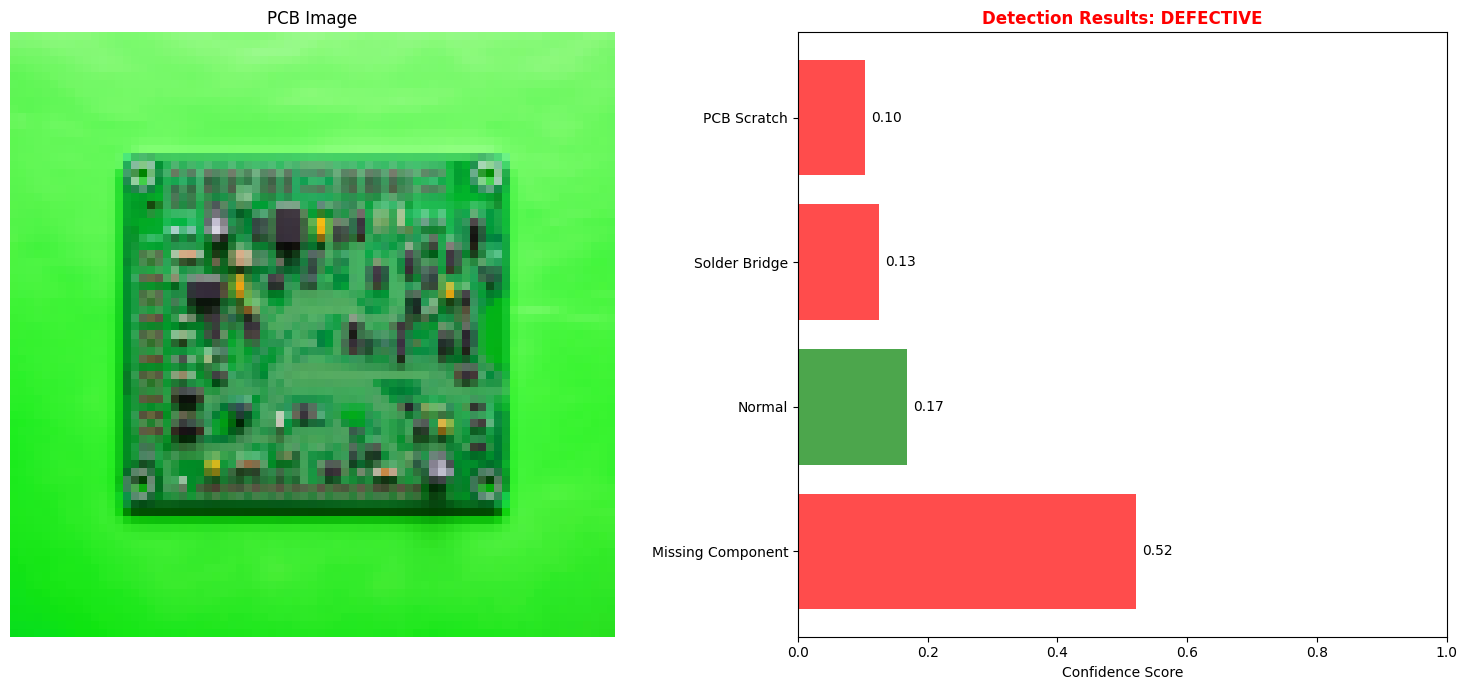

Comparison grid saved to results/all_pcbs_comparison.png


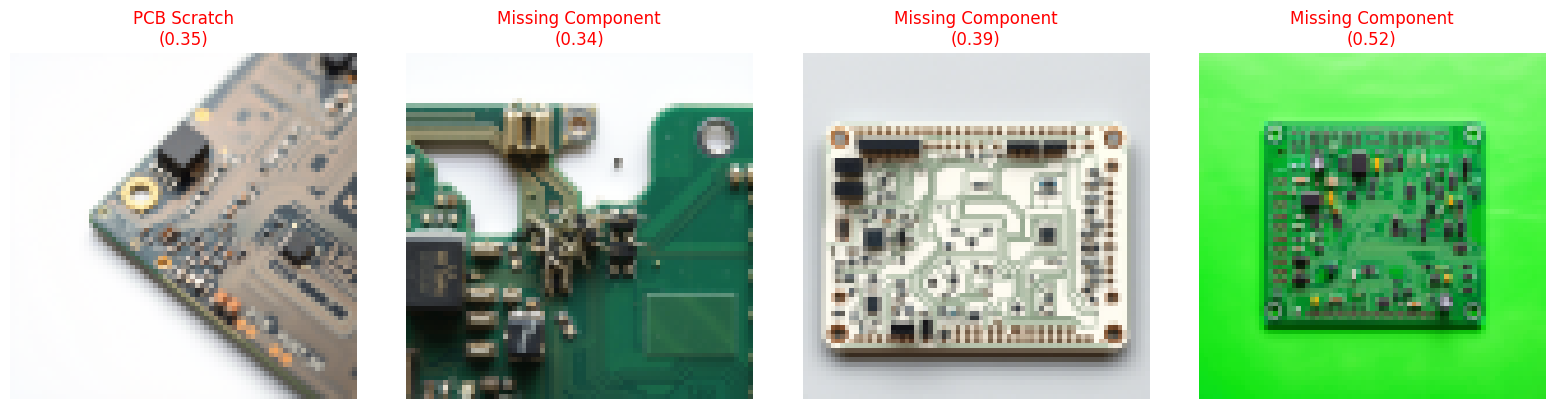

In [40]:
# Upload images or use sample images
# Try to upload images or use already uploaded ones
if 'google.colab' in str(get_ipython()):
    print("Please upload your PCB images for defect detection:")
    try:
        image_paths = upload_images()
    except Exception as e:
        print(f"Upload failed: {e}")
        image_paths = []

    # If upload failed or no images were uploaded, search directories
    if not image_paths:
        print("\nLooking for images in data directories...")
        image_paths = find_uploaded_images()
else:
    # Use sample images if not in Colab
    image_paths = [
        "data/images/normal/normal1.png",
        "data/images/normal/normal2.png",
        "data/images/defective/defective1.png",
        "data/images/defective/defective2.png"
    ]
    # Check if sample images exist
    missing_images = [img for img in image_paths if not os.path.exists(img)]
    if missing_images:
        print("Warning: Some sample images could not be found. Looking for any images...")
        image_paths = find_uploaded_images()

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

if image_paths:
    print(f"\nAnalyzing {len(image_paths)} PCB images with optimized batch processing...")

    # Process all images using the optimized batch processing function
    batch_results = detector.batch_detect(
        image_paths=image_paths,
        threshold=0.1,  # Lower threshold to see more potential defects
        top_k=5,        # Show top 5 categories
        enhance_prompts=True,
        batch_size=4   # Process 4 images at a time (adjust based on your GPU memory)
    )

    print("\nAnalysis complete! Visualizing results...")

    # Visualize each result individually
    for i, (image_path, result) in enumerate(zip(image_paths, batch_results)):
        output_path = f"results/image_{i+1}_detection.png"
        print(f"\nProcessing {os.path.basename(image_path)}...")

        if "error" in result:
            print(f"Error: {result['error']}")
            continue

        # Show detected defects
        if result['defects']:
            print(f"Top detected defects:")
            for defect, score in result['defects'].items():
                print(f"  - {defect}: {score:.4f}")
        else:
            print("No defects detected above threshold")

        print(f"Overall status: {'DEFECTIVE' if result['is_defective'] else 'NORMAL'}")

        # Visualize the result
        visualize_detection(image_path, result, output_path)

    # Create a comparison grid of all images
    create_comparison_grid(
        image_paths=image_paths,
        results=batch_results,
        output_path="results/all_pcbs_comparison.png"
    )
else:
    print("No images to analyze. Please upload images or provide valid paths.")

## Summarize Results

Let's create a summary of our detection results:

In [41]:
if 'batch_results' in locals() and batch_results:
    # Create a summary table
    print("\nSummary of PCB Defect Detection Results")
    print("-" * 80)
    print(f"{'Image':<30} {'Defective':<10} {'Top Defect':<20} {'Confidence':<10}")
    print("-" * 80)

    for image_path, result in zip(image_paths, batch_results):
        # Handle error case
        if "error" in result:
            print(f"{os.path.basename(image_path):<30} {'ERROR':<10} {result['error'][:30]:<30}")
            continue

        is_defective = result['is_defective']

        if result['defects']:
            top_defect = list(result['defects'].keys())[0]
            confidence = list(result['defects'].values())[0]
        else:
            top_defect = "None"
            confidence = 0.0

        # Get basename of image path for display
        img_name = os.path.basename(image_path)

        print(f"{img_name:<30} {str(is_defective):<10} {top_defect:<20} {confidence:.4f}")

    print("-" * 80)
else:
    print("No results to summarize.")


Summary of PCB Defect Detection Results
--------------------------------------------------------------------------------
Image                          Defective  Top Defect           Confidence
--------------------------------------------------------------------------------
defective1.png                 True       PCB Scratch          0.3492
defective2.png                 True       Missing Component    0.3366
normal1.png                    True       Missing Component    0.3878
normal2.png                    True       Missing Component    0.5202
--------------------------------------------------------------------------------


## Defect Distribution Analysis

Let's analyze the distribution of detected defects:

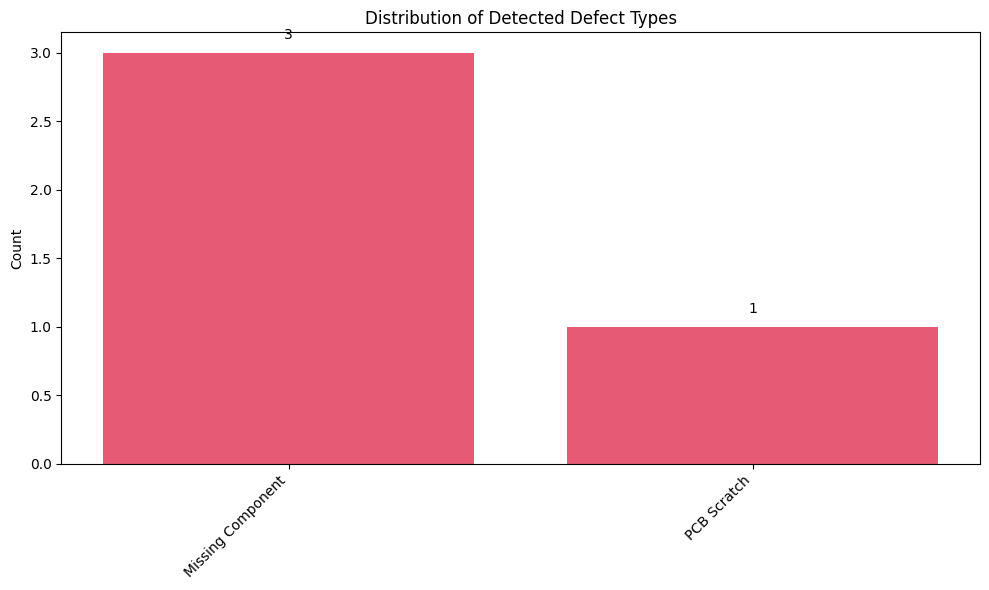

Defect distribution visualization saved to results/defect_distribution.png


In [42]:
if 'batch_results' in locals() and batch_results:
    # Count defect occurrences
    defect_counts = {}

    for result in batch_results:
        if "error" in result:
            continue

        if result['is_defective'] and result['defects']:
            # Get top defect for each image
            top_defect = list(result['defects'].keys())[0]
            if top_defect.lower() != "normal":
                if top_defect in defect_counts:
                    defect_counts[top_defect] += 1
                else:
                    defect_counts[top_defect] = 1

    if defect_counts:
        # Sort defects by frequency
        sorted_defects = sorted(defect_counts.items(), key=lambda x: x[1], reverse=True)
        categories = [item[0] for item in sorted_defects]
        counts = [item[1] for item in sorted_defects]

        # Create figure
        plt.figure(figsize=(10, 6))

        # Plot bar chart
        bars = plt.bar(categories, counts, color='crimson', alpha=0.7)

        # Add count labels on top of bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                   str(count), ha='center')

        plt.ylabel('Count')
        plt.title('Distribution of Detected Defect Types')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.savefig('results/defect_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Defect distribution visualization saved to results/defect_distribution.png")
    else:
        print("No defects detected in the analyzed images.")
else:
    print("No results to analyze.")

## Download Results

In Colab, you can download the analysis results:

In [43]:
if 'google.colab' in str(get_ipython()) and 'batch_results' in locals() and batch_results:
    # Create a ZIP file with all result images
    !zip -r /content/pcb_detection_results.zip results/

    # Provide download link
    from google.colab import files
    files.download('/content/pcb_detection_results.zip')

    print("\nDownload link created for results.")

  adding: results/ (stored 0%)
  adding: results/all_pcbs_comparison.png (deflated 19%)
  adding: results/defect_distribution.png (deflated 31%)
  adding: results/image_4_detection.png (deflated 33%)
  adding: results/image_2_detection.png (deflated 33%)
  adding: results/image_3_detection.png (deflated 33%)
  adding: results/image_1_detection.png (deflated 33%)
  adding: results/image_6_detection.png (deflated 33%)
  adding: results/image_5_detection.png (deflated 33%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download link created for results.


## Conclusion

In this notebook, we've demonstrated how to use Vision-Language Models (VLMs) for zero-shot detection of defects in PCB images. Key features:

1. **Zero-shot approach** allows defect detection without traditional training data
2. **Optimized batch processing** efficiently handles multiple images
3. **Google Colab integration** enables easy uploading and processing of PCB images
4. **Enhanced visualization** clearly presents detection results
5. **Robust error handling** improves reliability across various image types

### Next Steps

- Add more PCB images to improve detection robustness
- Fine-tune the defect category prompts for better detection
- Experiment with different VLM models to compare performance
- Create an ensemble approach using multiple models for better accuracy